# **Predicting patient no-shows and improving models with synthetic data**
---

## **The data**
Can we predict whether or not someone will show up to an appointment? There is a dataset from Brazil of patients and whether they show up to their hospital checkup appointments: (https://www.kaggle.com/joniarroba/noshowappointments).
The features for each patient are:

* ` PatientId `
* ` AppointmentID `
* ` Gender `
* ` ScheduledDay `
* ` AppointmentDay `
* ` Age `
* ` Neighbourhood `
* ` Scholarship `
* ` Hipertension `
* ` Diabetes `
* ` Alcoholism `
* ` Handcap `
* ` SMS_received `
* ` No-show `


# **The main problems**
When looking at patient dataset has about 100,000 patients, however it is skewed as around t 1/4 of the patients are no shows. Could more No-show patient data improve predictions? Lets see if generating synthetic data can improve predictions.

# **Libraries**

In [47]:
from pycaret.classification import * # Preprocessing, modelling, interpretation, deployment...
import pandas as pd # Basic data manipulation
import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps

# **Importing data**

In [169]:
# Read and output the top 5 rows
original_data = pd.read_csv('KaggleV2-May-2016.csv')
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


# **Load synthetic data**

In [170]:
synth_data = pd.read_csv('synth_data.csv')
synth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PatientId       40000 non-null  float64
 1   AppointmentID   40000 non-null  int64  
 2   Gender          40000 non-null  object 
 3   RegisterDay     40000 non-null  object 
 4   AppointmentDay  40000 non-null  object 
 5   Age             40000 non-null  int64  
 6   Neighbourhood   40000 non-null  object 
 7   Scholarship     40000 non-null  int64  
 8   Hipertension    40000 non-null  int64  
 9   Diabetes        40000 non-null  int64  
 10  Alcoholism      40000 non-null  int64  
 11  Handicap        40000 non-null  int64  
 12  SMS_received    40000 non-null  int64  
 13  No-show         40000 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 4.3+ MB


# **Extract Features**
Here I reformat the datetime variables ScheduleDay->RegisterDay and AppointmentDay, and add feature wait_time (the time between RegisterDay and AppointmentDay).

In [171]:

# Add No-show column back into training + test set
train["No-show"] = target_train
test["No-show"] = target_test

def extract_features(dataset):
    # get month, day name and hour from Start Time after convert
    dataset['Appointment_year'] = dataset['AppointmentDay'].dt.year
    dataset['Appointment_month'] = dataset['AppointmentDay'].dt.month
    dataset['Appointment_day'] = dataset['AppointmentDay'].dt.day
    dataset['Appointment_day_name'] = dataset['AppointmentDay'].dt.day_name()
    #appointment hour is always 0 so we leave it out
    
    # get month and day name and hour from Start Time after convert
    dataset['Register_year'] = dataset['RegisterDay'].dt.year
    dataset['Register_month'] = dataset['RegisterDay'].dt.month
    dataset['Register_day'] = dataset['RegisterDay'].dt.day
    dataset['Register_day_name'] = dataset['RegisterDay'].dt.day_name()
    dataset['Register_hour'] = dataset['RegisterDay'].dt.hour
    
    dataset['waiting_time'] = (dataset['AppointmentDay']-dataset['RegisterDay']).dt.days
    
    dataset.drop('AppointmentDay', axis=1, inplace=True)
    dataset.drop('RegisterDay', axis=1, inplace=True)
    
    
def convert_datetime(dataset):
    dataset.rename(columns={'Handcap':'Handicap'},inplace=True)
    dataset.rename(columns={"ScheduledDay":"RegisterDay"},inplace=True)
    dataset['AppointmentDay'] = pd.to_datetime(dataset['AppointmentDay']).dt.tz_localize(None)
    dataset['RegisterDay'] = pd.to_datetime(dataset['RegisterDay']).dt.tz_localize(None)
convert_datetime(original_data)
extract_features(original_data)
convert_datetime(synth_data)
extract_features(synth_data)

In [172]:
# Split real data into training + test set
train, test, target_train, target_test = train_test_split(original_data.drop("No-show", axis = 1), original_data["No-show"], test_size = 0.4, random_state = 42)
train["No-show"] = target_train
test["No-show"] = target_test

In [173]:
# Add the 40,000 synthetic rows of data to training data + remove dataset column
synth_train = pd.concat([train, synth_data])

In [174]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", synth_train.shape)
print("Testing size (real:", test.shape)

Training size (real): (66316, 22)
Training size (fake + real): (106316, 22)
Testing size (real: (44211, 22)


# **Visualising Data**
As mentioned the main problem with this dataset is a large class imbalance for the target feature `No-show`. I will model the data with the imbalance to see how it performs but there may be a way to improve it, synthetic data generation.

The other features look somewhat normal except some which have zero variance hence will be ignored.

In [175]:
original = original_data.copy(deep=True)
original['synthetic'] = 'No'
synthetic = synth_data.copy(deep=True)
synthetic['synthetic'] = 'Yes'
compare = pd.concat([synthetic, original])

Target looks like classification


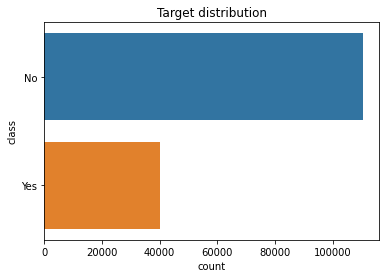

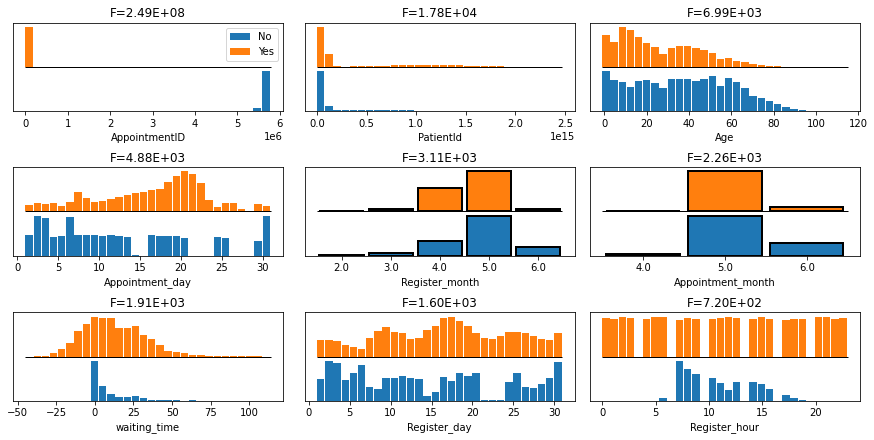

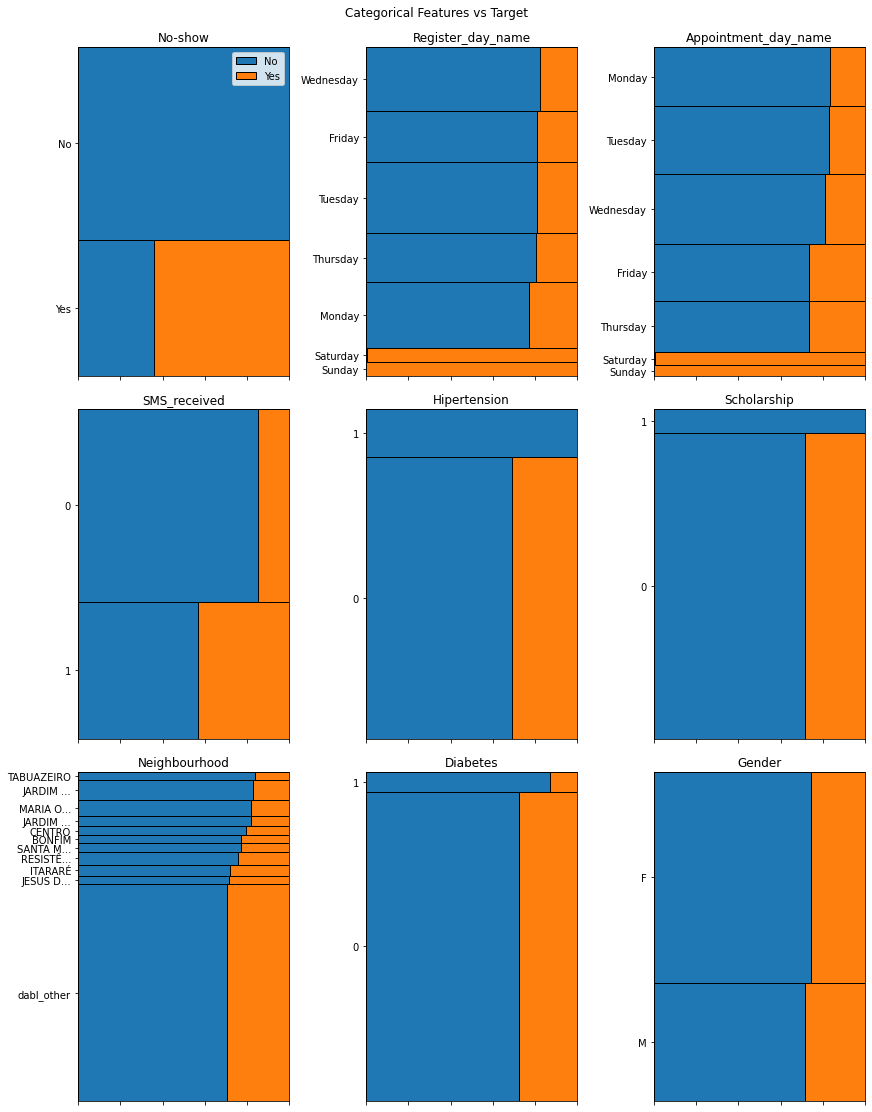

In [177]:
# Plot summaries of continuous + categorical features
## Type hints are used to force types on certain features
types = {"Age" : "continuous", "Appointment_month" : "continuous",
         "Register_hour" : "continuous", "Register_month" : "continuous",
        "waiting_time" : "continuous"}


db.plot(compare, y = "synthetic", type_hints = types, plot_pairwise = False)

Target looks like classification


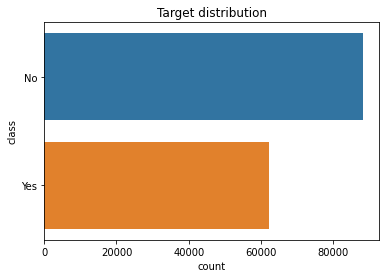

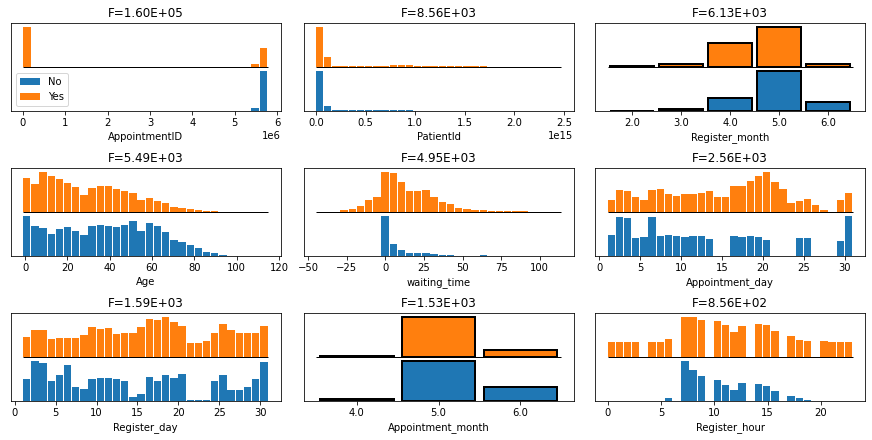

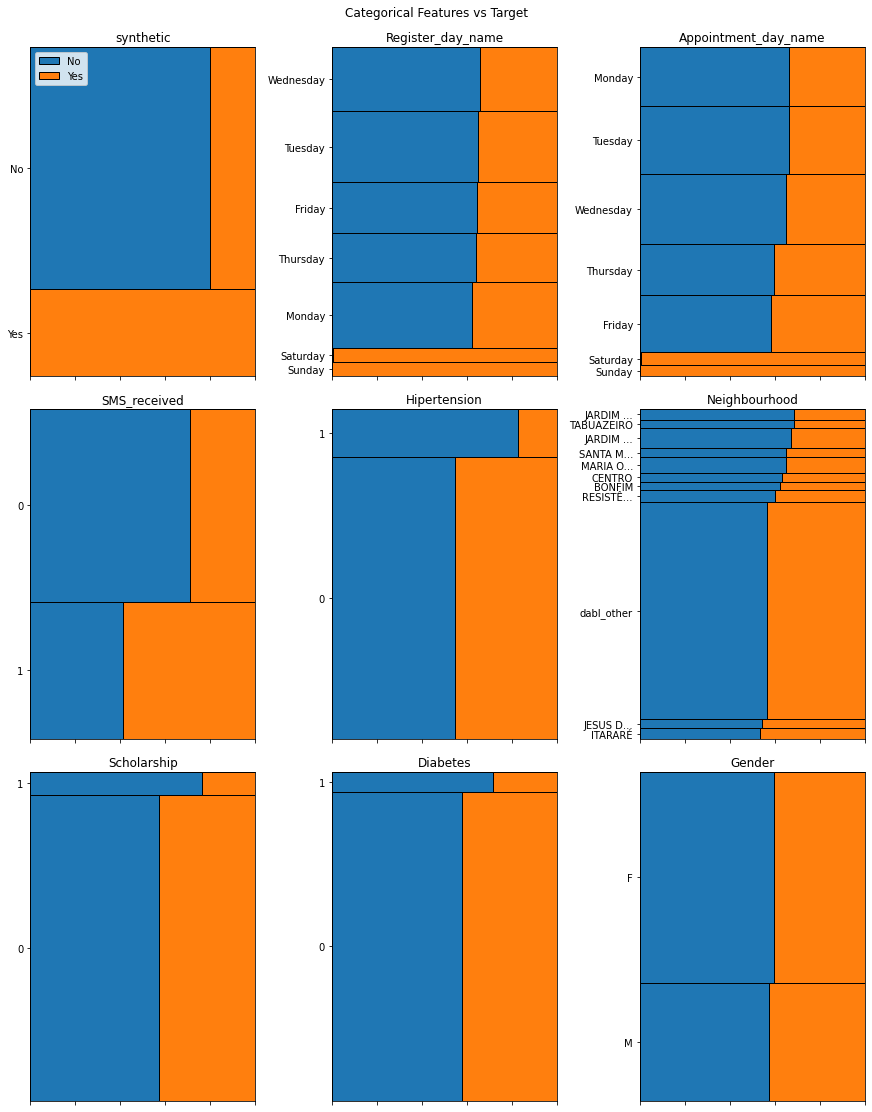

In [178]:
db.plot(compare, y = "No-show", type_hints = types, plot_pairwise = False)

Target looks like classification


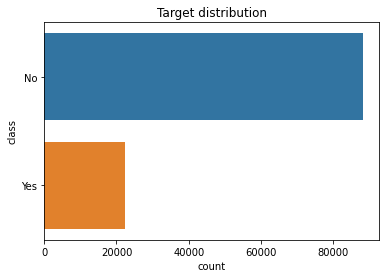

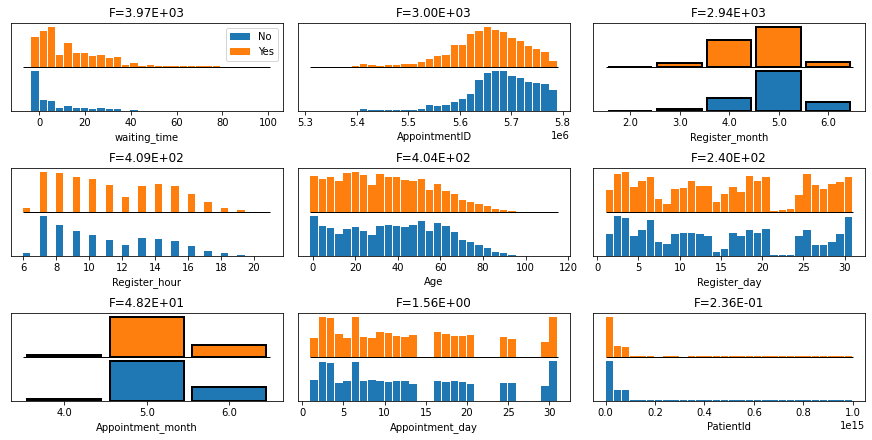

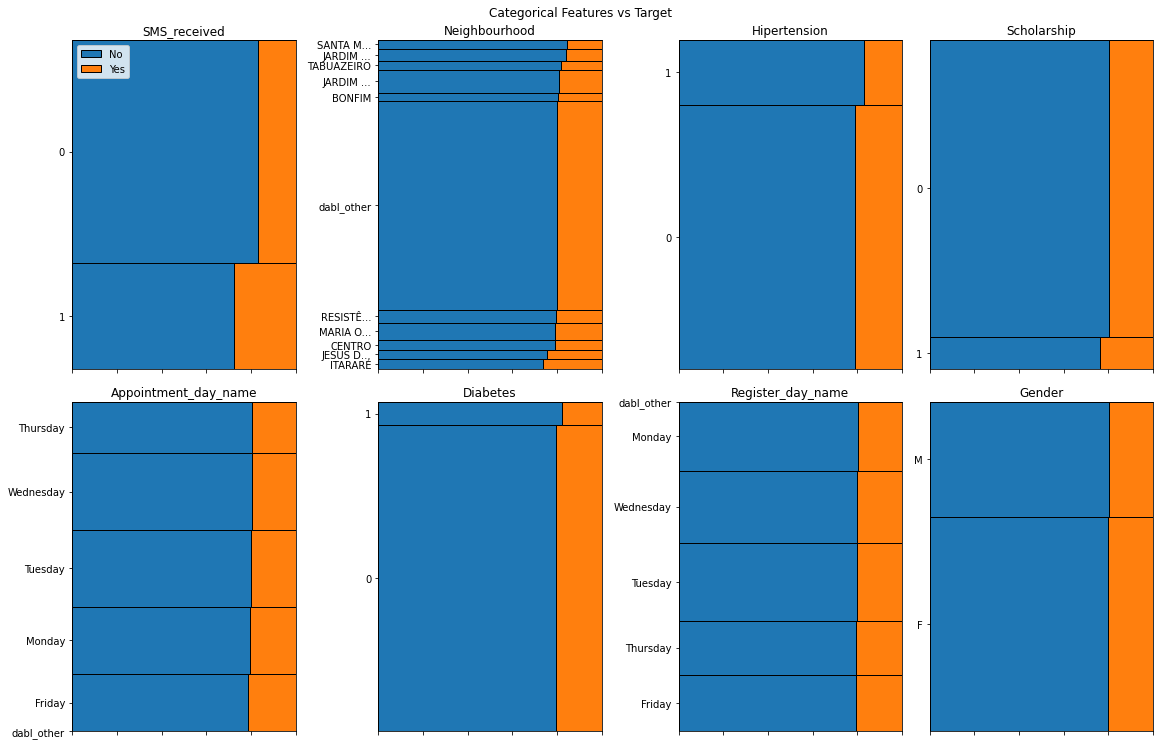

In [179]:
# Plot summaries of continuous + categorical features
## Type hints are used to force types on certain features
types = {"Age" : "continuous", "Appointment_month" : "continuous",
         "Register_hour" : "continuous", "Register_month" : "continuous",
        "waiting_time" : "continuous"}

db.plot(original_data, y = "No-show", type_hints = types, plot_pairwise = False)

# **First modelling w/original data**
I'll use `Pycaret` to model the data given it's easy of use and speed. It can handle a lot of the preprocessing, modelling, evaluation and interpretation. Given the dataset is ~1.5k rows the processing isn't too intensive but if it increased in size thankfully Pycaret has GPU functionality.

Ordinal features need to have their levels known and ordered using a dictionary which can quickly be done.

In [98]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PatientId             110527 non-null  float64
 1   AppointmentID         110527 non-null  int64  
 2   Gender                110527 non-null  object 
 3   Age                   110527 non-null  int64  
 4   Neighbourhood         110527 non-null  object 
 5   Scholarship           110527 non-null  int64  
 6   Hipertension          110527 non-null  int64  
 7   Diabetes              110527 non-null  int64  
 8   Alcoholism            110527 non-null  int64  
 9   Handicap              110527 non-null  int64  
 10  SMS_received          110527 non-null  int64  
 11  No-show               110527 non-null  object 
 12  Appointment_year      110527 non-null  int64  
 13  Appointment_month     110527 non-null  int64  
 14  Appointment_day       110527 non-null  int64  
 15  

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [101]:
# Target feature
target = "No-show"

# Continuous/numeric features
cont_feats = ["Age", "Appointment_year",  "Appointment_month", "Appointment_day",
              "Register_year", "Register_month", "Register_day",
              "Register_hour", "waiting_time"]

# Ordinal features
ord_feats = {}

# Categorical geatures
cat_feats = ["Gender", "Scholarship", "Hipertension", 
             "Diabetes", "Alcoholism", "Handicap", "SMS_received", 
             "Appointment_day_name", "Register_day_name"]

# Features to ignore
ignore = ["PatientId", "AppointmentID"]#ignore id variables and datetime type columns

Now with the features initalised they can be fed into pycaret's `setup` function involving steps...
* Feed in data + features
* Normalize continuous features + use `minimax` as the normalization method
* Use stratified k folding on the data
* Remove features with low variance
* Split the data into 70:30 train:test

There a lot on offer but not everything is used here.

In [109]:
# Run pycaret setup
setup(train, 
      target = target, 
      test_data = test,
      fold_strategy = "stratifiedkfold",
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True, verbose = False)
print("setup complete!")

setup complete!


Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months. Cross validation is also used.

In [110]:
compare_models(sort = "F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
nb,Naive Bayes,0.3404,0.5696,0.8432,0.2146,0.3420,0.0268,0.0547,0.0660
dt,Decision Tree Classifier,0.7268,0.5789,0.3282,0.3281,0.3281,0.1566,0.1566,0.3710
knn,K Neighbors Classifier,0.7749,0.6735,0.2076,0.3972,0.2726,0.1547,0.1661,7.5760
qda,Quadratic Discriminant Analysis,0.5484,0.5004,0.4196,0.2047,0.2696,0.0017,0.0010,0.9410
et,Extra Trees Classifier,0.7841,0.7182,0.1945,0.4310,0.2680,0.1621,0.1798,4.8390
rf,Random Forest Classifier,0.7997,0.7359,0.1540,0.5248,0.2380,0.1605,0.2011,3.3530
xgboost,Extreme Gradient Boosting,0.7985,0.7407,0.0971,0.5235,0.1637,0.1069,0.1574,4.9420
catboost,CatBoost Classifier,0.8000,0.7432,0.0764,0.5600,0.1344,0.0899,0.1496,14.9060
lda,Linear Discriminant Analysis,0.7897,0.6737,0.0369,0.3420,0.0665,0.0279,0.0514,1.2570
lightgbm,Light Gradient Boosting Machine,0.7992,0.7420,0.0349,0.6053,0.0659,0.0448,0.1087,0.7410


GaussianNB(priors=None, var_smoothing=1e-09)

In [104]:
catboost = create_model("catboost") # Create the catboost classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7993,0.7328,0.0772,0.5445,0.1352,0.0892,0.1460
1,0.7975,0.7366,0.0712,0.5134,0.1251,0.0795,0.1313
2,0.8008,0.7483,0.0786,0.5730,0.1383,0.0938,0.1556
3,0.8011,0.7508,0.0801,0.5775,0.1407,0.0959,0.1584
4,0.8016,0.7460,0.0786,0.5889,0.1387,0.0954,0.1601
5,0.8044,0.7539,0.0809,0.6527,0.1439,0.1037,0.1795
6,0.8009,0.7403,0.0720,0.5808,0.1281,0.0872,0.1509
7,0.7982,0.7365,0.0787,0.5222,0.1368,0.0883,0.1409
8,0.8020,0.7421,0.0787,0.5955,0.1390,0.0962,0.1620
9,0.8002,0.7472,0.0720,0.5673,0.1277,0.0859,0.1471


In [111]:
pred_holdout = predict_model(catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8031,0.7464,0.0723,0.5600,0.1280,0.0862,0.1465


In [112]:
dt = create_model("dt") # Create the dt classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7312,0.5806,0.3272,0.3349,0.3310,0.1628,0.1628
1,0.7272,0.5778,0.3242,0.3273,0.3258,0.1548,0.1548
2,0.7229,0.5747,0.3234,0.3201,0.3218,0.1476,0.1476
3,0.7295,0.5822,0.3338,0.3343,0.3341,0.1644,0.1644
4,0.7275,0.5768,0.3190,0.3260,0.3225,0.1520,0.1520
5,0.7192,0.5745,0.3279,0.3162,0.3219,0.1450,0.1450
6,0.7358,0.5874,0.3311,0.3439,0.3374,0.1724,0.1725
7,0.7287,0.5855,0.3445,0.3362,0.3403,0.1696,0.1696
8,0.7212,0.5746,0.3274,0.3186,0.3230,0.1474,0.1474
9,0.7246,0.5752,0.3234,0.3230,0.3232,0.1504,0.1504


In [113]:
pred_holdout = predict_model(dt)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.7338,0.5900,0.3489,0.3392,0.3440,0.1770,0.1771


# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [105]:
ord_feats = {}

If we use pycaret without shuffling the test data we see strange kfold validation stats.

In [183]:
setup(synth_train, 
      target = target, 
      test_data = test,
      fold_strategy = "stratifiedkfold",
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True, verbose = False)
print("setup complete!")

setup complete!


In [184]:
et = create_model("et") # Create the catboost classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5685,0.7086,0.2292,0.7246,0.3483,0.1405,0.1928
1,0.5654,0.7122,0.2306,0.7090,0.3480,0.1342,0.1822
2,0.7445,0.8444,0.5967,0.8507,0.7014,0.4898,0.5134
3,0.9091,0.9788,0.9598,0.8724,0.9140,0.8182,0.8224
4,0.9131,0.9820,0.9648,0.8752,0.9178,0.8261,0.8305
5,0.9122,0.9787,0.9611,0.8764,0.9168,0.8244,0.8283
6,0.9127,0.9785,0.9635,0.8754,0.9174,0.8253,0.8296
7,0.9096,0.9791,0.9596,0.8732,0.9144,0.8191,0.8232
8,0.9097,0.9781,0.9583,0.8743,0.9143,0.8193,0.8231
9,0.9117,0.9789,0.9596,0.8765,0.9162,0.8232,0.8270


In [180]:
# Run pycaret setup w/synthetic data
# https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=setup#pycaret.classification.setup 
#test_data is the hold out set, we run 10 fol cross validation
setup(synth_train.sample(frac=1), 
      target = target, 
      test_data = test,
      fold_strategy = "stratifiedkfold",
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True, verbose = False)
print("setup complete!")

setup complete!


Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [107]:
#Models sorted by f1 score
compare_models(sort = "F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8255,0.9117,0.7788,0.8414,0.7813,0.6516,0.6672,7.0960
rf,Random Forest Classifier,0.8373,0.9214,0.7666,0.8738,0.7808,0.6754,0.6935,4.6150
dt,Decision Tree Classifier,0.7976,0.7978,0.7872,0.7877,0.7700,0.5956,0.6081,0.4570
catboost,CatBoost Classifier,0.8419,0.9250,0.7475,0.8952,0.7683,0.6848,0.7038,16.0910
xgboost,Extreme Gradient Boosting,0.8409,0.9240,0.7443,0.8912,0.7653,0.6829,0.7005,7.7090
gbc,Gradient Boosting Classifier,0.8335,0.9190,0.7449,0.8746,0.7622,0.6681,0.6846,5.0530
ada,Ada Boost Classifier,0.8208,0.9106,0.7439,0.8524,0.7612,0.6426,0.6571,1.0880
lightgbm,Light Gradient Boosting Machine,0.8410,0.9239,0.7350,0.9017,0.7590,0.6831,0.7018,1.0200
knn,K Neighbors Classifier,0.8044,0.8816,0.7269,0.8425,0.7520,0.6096,0.6240,19.4760
svm,SVM - Linear Kernel,0.7537,0.0000,0.6970,0.7708,0.7200,0.5080,0.5139,0.2440


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=2002, verbose=0,
                     warm_start=False)

A CatBoost Classifier performed best:

In [181]:
#sorted by accuracy, each row corresponds to a cross validation
#https://pycaret.readthedocs.io/en/latest/api/classification.html?highlight=create_model#pycaret.classification.create_model
et = create_model("et") # Create the catboost classifier

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8362,0.9174,0.8001,0.8643,0.8310,0.6726,0.6745
1,0.8299,0.9141,0.7966,0.8552,0.8249,0.6598,0.6614
2,0.8337,0.9109,0.7924,0.8656,0.8274,0.6676,0.6700
3,0.8339,0.9138,0.7941,0.8646,0.8279,0.6679,0.6702
4,0.8296,0.9110,0.7885,0.8610,0.8232,0.6593,0.6617
5,0.8335,0.9148,0.7945,0.8636,0.8276,0.6672,0.6694
6,0.8353,0.9132,0.7941,0.8672,0.8291,0.6707,0.6732
7,0.8322,0.9101,0.7883,0.8660,0.8253,0.6645,0.6673
8,0.8414,0.9194,0.8104,0.8657,0.8371,0.6829,0.6843
9,0.8401,0.9126,0.7962,0.8747,0.8336,0.6803,0.6831


A gradient boosting classifier was decided upon.

In [182]:
pred_holdout = predict_model(et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7634,0.7188,0.3134,0.3869,0.3463,0.2038,0.2054


In [117]:
synth_catboost = create_model("catboost")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5345,0.7280,0.1122,0.7491,0.1952,0.0738,0.1405
1,0.5356,0.7333,0.1133,0.7556,0.1971,0.0758,0.1443
2,0.7434,0.8596,0.5357,0.9212,0.6775,0.4881,0.5378
3,0.9424,0.9895,0.9568,0.9307,0.9436,0.8849,0.8852
4,0.9437,0.9907,0.9632,0.9276,0.9451,0.8873,0.8880
5,0.9470,0.9907,0.9619,0.9346,0.9480,0.8939,0.8943
6,0.9471,0.9904,0.9630,0.9340,0.9483,0.8942,0.8947
7,0.9408,0.9891,0.9583,0.9266,0.9422,0.8816,0.8822
8,0.9412,0.9889,0.9562,0.9290,0.9424,0.8824,0.8828
9,0.9441,0.9896,0.9577,0.9330,0.9452,0.8882,0.8885


In [121]:
pred_holdout = predict_model(synth_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7892,0.7393,0.1798,0.4345,0.2544,0.1555,0.1761


In [128]:
pred = predict_model(synth_catboost, data=test)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,...,Appointment_day_name,Register_year,Register_month,Register_day,Register_day_name,Register_hour,waiting_time,No-show,Label,Score
84674,2.759575e+13,5756417,F,20,ILHA DAS CAIEIRAS,0,0,0,0,0,...,Wednesday,2016,6,1,Wednesday,8,-1,No,No,0.9285
3635,9.673194e+14,5523159,F,37,RESISTÊNCIA,0,0,0,0,0,...,Tuesday,2016,3,29,Tuesday,16,34,No,Yes,0.6218
16605,3.951641e+12,5693080,F,38,MARIA ORTIZ,0,0,0,0,0,...,Friday,2016,5,12,Thursday,17,7,Yes,No,0.5410
103942,9.173245e+14,5654129,F,24,SANTO ANDRÉ,0,0,0,0,0,...,Friday,2016,5,3,Tuesday,13,30,Yes,No,0.5915
274,3.995366e+12,5641070,F,41,MARIA ORTIZ,0,0,0,0,0,...,Friday,2016,4,29,Friday,12,-1,No,No,0.9683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77440,5.134886e+13,5665127,F,10,BELA VISTA,0,0,0,0,0,...,Friday,2016,5,5,Thursday,13,7,No,No,0.6927
84883,5.821357e+13,5774289,F,4,CENTRO,0,0,0,0,0,...,Monday,2016,6,6,Monday,8,-1,No,No,0.9802
57918,1.681822e+13,5641394,F,29,CONQUISTA,1,0,0,0,0,...,Thursday,2016,4,29,Friday,13,12,No,No,0.6335
80372,5.649478e+08,5648719,M,58,MARUÍPE,0,0,0,0,0,...,Thursday,2016,5,2,Monday,16,2,No,No,0.7637


# **Conclusion**
Adding synthetic data seems to improve accuracy accross the board.